In [3]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # For export


from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

# Basics and Things for reproducibility

In [5]:
import torch
print("Using torch", torch.__version__)

torch.manual_seed(42) # Setting the seed

Using torch 2.0.1+cu117


In [88]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [10]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [14]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


In [16]:
y.backward()

In [17]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


In [18]:
torch.cuda.is_available()

True

In [19]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [20]:
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# XOR

In [21]:
import torch.nn as nn

In [22]:
import torch.nn.functional as F

In [37]:
class XORClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
            
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
            
    def forward(self, x):  # compute x, input nn = MyModule(); nn(x)
        
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        
        return x

In [38]:
model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

XORClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [39]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [75]:
import torch.utils.data as data
import torch.utils.data

In [41]:
class XORDataset(data.Dataset):
    def __init__(self, size, std = 0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()
    
    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) ==1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size
    
    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [42]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.8675, 0.9484]), tensor(0))


In [72]:
def visualize_samples(data, label):

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
        
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

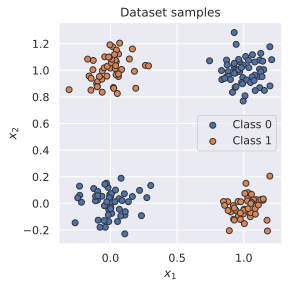

In [73]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [79]:
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=True)

In [80]:
data_inputs, data_labels = next(iter(data_loader))

In [81]:
len(data_inputs)

32

In [82]:
loss_module = nn.BCEWithLogitsLoss() # binary cross entropy appied on the log of sigmoid (more stable)

In [86]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

# remember to inizialise weights to 0 before each batch!
# optimizer.zero_grad()

In [85]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [89]:
# Push model to device. Has to be only done once
model.to(device)

XORClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [90]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In [143]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=1):
    # Set model to train mode
    model.train() # important > remember to switch!
    
    # training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            # 1. move data on GPU
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # 2. run the NN model
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            # 3. Loss
            loss = loss_module(preds, data_labels.float())
            
            # 4. Backpropagate
            optimizer.zero_grad() # very important
            loss.backward()
            
            # 5. update
            optimizer.step()
    

In [144]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
# save to disk
state_dict = model.state_dict()
print(state_dict)


OrderedDict([('linear1.weight', tensor([[ 1.9051,  1.7964],
        [-2.6556,  2.0300],
        [-0.1848,  0.0671],
        [-1.6663,  2.4583]], device='cuda:0')), ('linear1.bias', tensor([-0.2332, -0.9128,  0.6019,  0.6376], device='cuda:0')), ('linear2.weight', tensor([[ 2.4591,  2.9680,  0.2054, -2.8593]], device='cuda:0')), ('linear2.bias', tensor([0.5936], device='cuda:0'))])


In [94]:
# torch.save(object, filename). For the filename, any extension can be used
#torch.save(state_dict, "our_model.tar")


In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
#state_dict = torch.load("our_model.tar")

# Create a new model and load the state
#new_model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
#new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

In [146]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [147]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [148]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


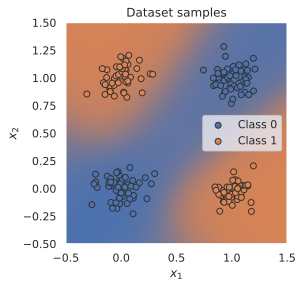

In [142]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

In [158]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%reload_ext tensorboard

In [150]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)

        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)

    writer.close()

In [151]:
model = XORClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)


  0%|          | 0/100 [00:00<?, ?it/s]

In [170]:
%tensorboard --logdir run/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-05-17 16:44:22.165266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-17 16:44:23.322508: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E0517 16:44:23.347449 140266765692928 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/data0/home/h21/luas6629/venv/lib/python3.10/site-

# Soft-DTW

In [171]:
# https://github.com/Maghoumi/pytorch-softdtw-cuda

In [186]:
from soft_dtw_cuda import SoftDTW

In [215]:
np.random.randint(low=5)

0

In [221]:
# Create the sequences
batch_size, len_x, len_y, dims = 1, 15, 12, 5
x = torch.rand((batch_size, np.random.randint(len_x), dims), requires_grad=True)
y = torch.rand((batch_size, len_y, dims))
# Transfer tensors to the GPU
x = x.cuda()
y = y.cuda()

# Create the "criterion" object
sdtw = SoftDTW(use_cuda=True, gamma=0.1)

# Compute the loss value
loss = sdtw(x, y)  # Just like any torch.nn.xyzLoss()

# Aggregate and call backward()
loss.mean().backward()

In [226]:
x = torch.rand((8, 32, 5), requires_grad=True).cuda()
y = torch.rand((8, 12, 5)).cuda()

In [229]:
loss = sdtw(x, y)  # Just like any torch.nn.xyzLoss()
loss.mean().backward()

loss

tensor([15.4025, 17.6278, 19.3245, 19.0892, 19.0836, 16.1644, 15.6968, 14.4834],
       device='cuda:0', grad_fn=<_SoftDTWCUDABackward>)

# AE

In [193]:
x

tensor([[[0.7952, 0.5168, 0.9796, 0.0915, 0.1456],
         [0.0737, 0.1835, 0.6049, 0.8345, 0.0907],
         [0.1185, 0.3148, 0.7966, 0.7641, 0.4492],
         [0.9561, 0.6820, 0.9700, 0.5013, 0.1904],
         [0.5056, 0.6584, 0.6955, 0.4981, 0.5171],
         [0.5949, 0.3898, 0.6224, 0.1818, 0.3900],
         [0.7696, 0.6528, 0.7798, 0.1670, 0.3528],
         [0.2411, 0.1110, 0.2947, 0.4680, 0.4634],
         [0.4691, 0.1842, 0.4661, 0.6326, 0.8591],
         [0.8025, 0.0821, 0.1815, 0.8944, 0.8394],
         [0.7775, 0.2421, 0.9217, 0.0142, 0.1024],
         [0.5448, 0.7325, 0.0287, 0.5736, 0.4925],
         [0.4342, 0.1084, 0.2603, 0.5235, 0.6196],
         [0.8136, 0.3229, 0.9733, 0.6883, 0.1603],
         [0.0022, 0.8362, 0.5378, 0.4498, 0.3345]],

        [[0.7351, 0.3201, 0.1342, 0.8472, 0.2856],
         [0.7879, 0.1562, 0.3995, 0.2260, 0.5213],
         [0.4409, 0.6492, 0.1122, 0.0590, 0.8976],
         [0.1172, 0.6686, 0.0658, 0.5974, 0.4894],
         [0.2541, 0.4897, 0.5